In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

import torch
import dngo_sample
from importlib import reload as R

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', size=15.0, family='serif')
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]

## Utility functions

In [3]:
def f(x):
    return np.sinc(x * 10 - 5)

def get_toy_dataset(num_points=20):
    # Fix the random state
    rng = np.random.RandomState(42)

    x = rng.rand(num_points)
    y = f(x)
    
    toy_dataset = x, y
    return toy_dataset

def visualize_dataset(x, y):
    
    grid = np.linspace(0, 1, 100)
    fvals = f(grid)
    
    plt.title("Toy dataset - Visualization")
    plt.plot(grid, fvals, "k--", label="True function")
    plt.plot(x, y, "ro", label="Observed data points")
    plt.grid()
    plt.ylabel("f(x)")
    plt.xlabel("x-axis")
    plt.xlim(0, 1)
    plt.legend()

    plt.show()

def prepare_toy_data(X, y, D_in):
    X = torch.from_numpy(X)
    y = torch.from_numpy(y)

    X = X.view(-1, D_in)

    X = X.float()
    y = y.float()
    return X, y

def plot_loss(x, y, title, xlabel, ylabel, loss_type):
    plt.figure()
    plt.grid()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(x, y, label=loss_type)
    plt.legend()
    plt.show()
    return

In [4]:
D = get_toy_dataset()

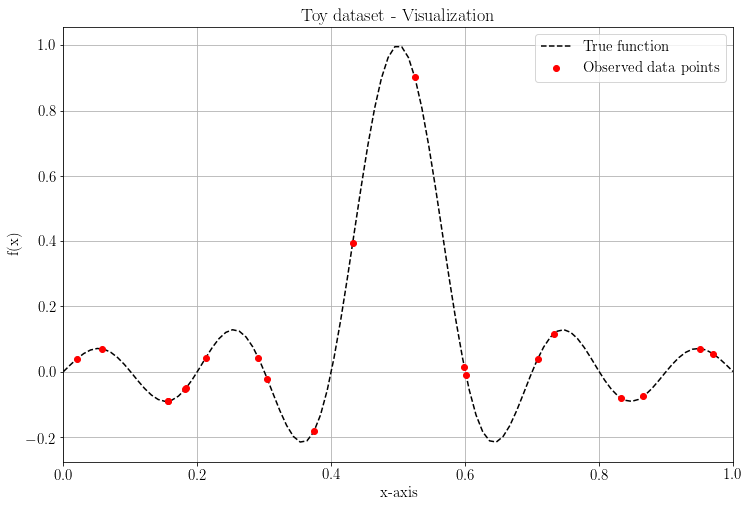

In [5]:
visualize_dataset(D[0], D[1])

In [6]:
X, y = D

In [7]:
# N is batch size; D_in is input dimension;
# H_i are the hidden dimensions; D_out is output dimension.
N, D_in, H1, H2, H3, D_out = len(X), 1, 40, 45, 50, 1

In [8]:
X, y = prepare_toy_data(X, y, D_in)

In [9]:
model = dngo_sample.surrogate_nn(D_in, H1, H2, H3, D_out)

In [10]:
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

100%|██████████| 1000/1000 [00:00<00:00, 1711.77it/s]


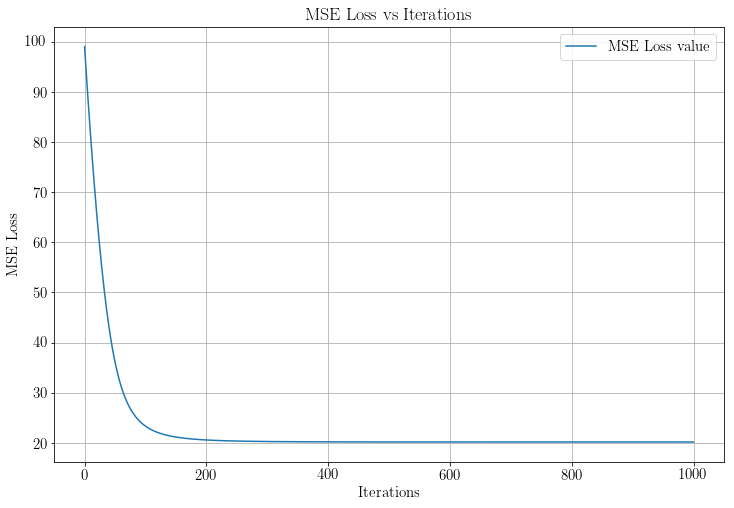

In [11]:
num_epochs = 1000
loss_arr = []

for t in tqdm.trange(num_epochs):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred, _ = model(X)

    # Compute loss
    loss = criterion(y_pred, y)
    loss_arr.append(loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plot_loss([i for i in range(num_epochs)], loss_arr, title="MSE Loss vs Iterations", 
          xlabel="Iterations", ylabel="MSE Loss", loss_type="MSE Loss value")

In [12]:
y_pred, out_hidden = model(X)

In [13]:
Phi = out_hidden
alpha = torch.Tensor([1.0])
beta = torch.Tensor([1000.0])
lambda_ = torch.Tensor([0.2])
c = torch.mean(torch.stack([x for x in X]))
Gamma = np.random.uniform(low=0.0, high=1.1, size=(D_in,))
Gamma = torch.from_numpy(Gamma)
Gamma = torch.diag(Gamma)

In [14]:
def compute_prior(X, c, Gamma, lambda_):
    out = []
    for x in X:
        v1 = torch.transpose((x-c), 0,0)
        t = (x-c).double()
        v2 = torch.mv(Gamma, t).float()
        val = torch.dot(v1, v2)
        out.append(val+lambda_)
    return out

In [15]:
batch_prior = compute_prior(X, c, Gamma, lambda_)

In [16]:
def compute_intermediate_quantitites(X, y,  c, Gamma, lambda_, Phi, alpha, beta):
    D = Phi.size()[1]
    quant1 = beta[0]*torch.mm(torch.transpose(Phi, 0,1),Phi)

    identity = torch.diag(torch.ones(D))
    quant2 = alpha[0]*identity
    
    K = quant1+quant2
    
    batch_prior = compute_prior(X, c, Gamma, lambda_)
    y_tilda = y - torch.cat(batch_prior)
    temp_mat = torch.mm(K.inverse(), torch.transpose(Phi, 0, 1))
    m = beta[0]*(torch.mv(temp_mat, y_tilda))
    
    return m, K

In [17]:
m, K = compute_intermediate_quantitites(X, y,  c, Gamma, lambda_, Phi, alpha, beta)

In [18]:
# All parameters and hyperparameters
Theta = {'c': c, 'Gamma': Gamma, 'lambda_': lambda_, 'Phi': Phi, 'alpha': alpha, 'beta': beta}

In [19]:
# Observed data
D = (X, y)

In [20]:
def prior(X, c, Gamma, lambda_):
    out = []
    for x in X:
        v1 = torch.transpose((x-c), 0,0)
        t = (x-c).double()
        v2 = torch.mv(Gamma, t).float()
        val = torch.dot(v1, v2)
        out.append(val+lambda_)
    return out

In [21]:
def compute_others(D, Theta):
    X, y = D
    c, Gamma, lambda_, Phi = Theta['c'], Theta['Gamma'], Theta['lambda_'], Theta['Phi']
    alpha, beta = Theta['alpha'], Theta['beta']
    
    D = Phi.size()[1]
    quant1 = beta[0]*torch.mm(torch.transpose(Phi, 0,1),Phi)
    identity = torch.diag(torch.ones(D))
    quant2 = alpha[0]*identity
    
    K = quant1+quant2
    
    batch_prior = prior(X, c, Gamma, lambda_)
    y_tilda = y - torch.cat(batch_prior)
    temp_mat = torch.mm(K.inverse(), torch.transpose(Phi, 0, 1))
    m = beta[0]*(torch.mv(temp_mat, y_tilda))
    
    return m, K

In [22]:
def pred_mean(x, hidden_out_x, D, Theta, others):
    X, y = D
    m, K = others
    c, Gamma, lambda_, Phi = Theta['c'], Theta['Gamma'], Theta['lambda_'], Theta['Phi']
    alpha, beta = Theta['alpha'], Theta['beta']

    
    q1 = torch.dot(m, hidden_out_x)
    pr = prior(x.view(1,-1), c, Gamma, lambda_)
    return q1 + pr[0]

In [23]:
def pred_var(x, hidden_out_x, D, Theta, others):
    X, y = D
    m, K = others
    c, Gamma, lambda_, Phi = Theta['c'], Theta['Gamma'], Theta['lambda_'], Theta['Phi']
    alpha, beta = Theta['alpha'], Theta['beta']
    
    q1 = torch.mv(K.inverse(), hidden_out_x)
    q2 = torch.dot(hidden_out_x , q1)
    
    return q2 + 1.0/beta[0]

In [24]:
X_linspace = np.linspace(0, 1, 100)
X_linspace = torch.from_numpy(X_linspace)
X_linspace = X_linspace.view(-1, D_in)
X_linspace = X_linspace.float()

In [25]:
y_ls_pred, X_ls_hidden_out = model(X_linspace)

In [26]:
m, K = compute_others(D, Theta)
others = (m, K)

In [27]:
mean_arr, var_arr = [], []
for i in tqdm.trange(X_linspace.size()[0]):
    x = X_linspace[i]
    hidden_out_x = X_ls_hidden_out[i]
    mean_arr.append(pred_mean(x, hidden_out_x, D, Theta, others))
    var_arr.append(pred_var(x, hidden_out_x, D, Theta, others))

100%|██████████| 100/100 [00:00<00:00, 5098.22it/s]


In [28]:
X,  y = D

In [29]:
X = list(X.numpy())
y = list(y.numpy())
m = [x.data for x in mean_arr]
v = [x.data for x in var_arr]

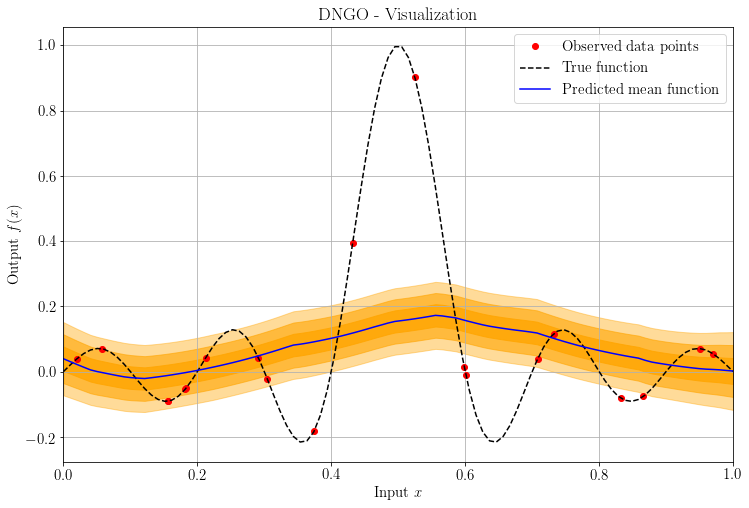

In [30]:
X_lsp = [x[0] for x in list(X_linspace.numpy()) ]
f_lsp = [f(z) for z in X_lsp]

plt.title("DNGO - Visualization")

plt.plot(X, y, "ro", label="Observed data points")
plt.grid()
plt.plot(X_lsp, f_lsp, "k--", label="True function")
plt.plot(X_lsp, m, "blue", label="Predicted mean function")
plt.fill_between(X_lsp, m + np.sqrt(v), m - np.sqrt(v), color="orange", alpha=0.8)
plt.fill_between(X_lsp, m + 2 * np.sqrt(v), m - 2 * np.sqrt(v), color="orange", alpha=0.6)
plt.fill_between(X_lsp, m + 3 * np.sqrt(v), m - 3 * np.sqrt(v), color="orange", alpha=0.4)
plt.xlim(0, 1)
plt.xlabel(r"Input $x$")
plt.ylabel(r"Output $f(x)$")
plt.legend()
plt.show()